# Deep Dreaming with Tf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import IPython.display as display
import urllib.request

In [2]:
def load_img(image_path):
  max_size = 512
  image = Image.open(image_path)
  image_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

  if (y := tf.reduce_max(image_shape)) > 512 :
     scale = max_size / y
     new_shape = tf.cast(scale * image_shape, tf.int32)
     image = tf.image.resize(image, new_shape)
  image = tf.expand_dims(image, axis=0)
  return image.numpy().astype("uint8")


In [3]:
def show(image):
  image = image[0]
  image = Image.fromarray(image)
  display.clear_output(wait=True)
  display.display_png(image)

In [4]:
def preprocess_img(image_path):
  image = load_img(image_path)
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  return image

In [5]:
def deprocess_img(image_tensor):
  image = image_tensor.numpy()
  x = image.copy()
  x =  255*(x + 1.0)/2.0
  return x.astype("uint8")

### testing load_img and show functions

In [18]:
img = load_img("132.jpg")

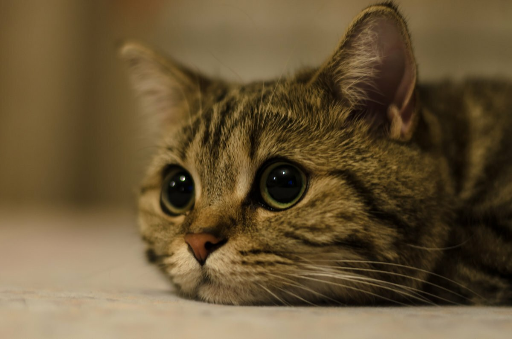

In [19]:
show(img)

### Loading InceptionV3 model

In [9]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top = False)

87910968/87910968 [==============================] - 1s 0us/step


In [10]:
# Maximize the activations of these layers
names = ['mixed3','mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [11]:
def calc_loss(img, model):
  layer_activations = model(img)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  return  tf.reduce_sum(losses)

## Gradient Ascent

In [12]:
@tf.function()
def gradient_ascent(img, step_size, model):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = calc_loss(img, model)
  gradients = tape.gradient(loss, img)
  gradients /= tf.math.reduce_std(gradients)
  img = tf.add(img , gradients * tf.cast(step_size , tf.float32))
  img = tf.clip_by_value(img, -1, 1)

  return img, loss

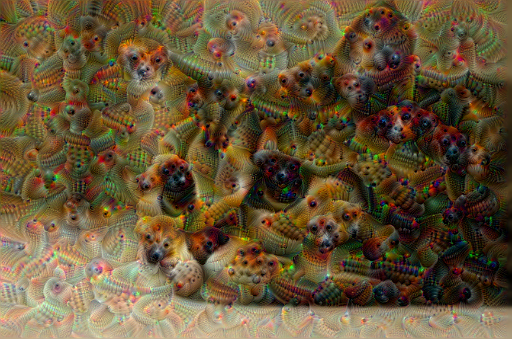

In [20]:
OCTAVE_SCALE = 1.30
img = preprocess_img("/content/132.jpg")
img = tf.Variable(img, tf.float32)
image_size = tf.shape(img)[1:-1]
float_size = tf.cast(image_size, tf.float32)

epochs = 31
step_size = 0.01
history = []

for n in range(-2, 3):
    new_shape = tf.cast(float_size * (OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape)
    for i in range(epochs):
        img, loss = gradient_ascent(img, step_size, model)
        if i % 10 ==0 :
            show(deprocess_img(img))
            print(f"""
            loss: {loss}
            epoch: {i}
            """)
        history.append(loss)

final_image = deprocess_img(tf.image.resize(img, image_size))

show(final_image)

In [22]:
Image.fromarray(final_image[0]).save("deepdream.png")